# Mark rooftops with u-net SHARP
https://arxiv.org/pdf/2107.12461.pdf

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate, DepthwiseConv2D, ReLU, Add, Conv1D, LayerNormalization, \
                         Layer, Flatten, MaxPooling1D, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler
import h5py

from tensorflow.image import resize
import keras.backend as K

### Load data

In [3]:
X_train = np.load("data/u_net_roofs/X_data.npy")
y_train = np.load("data/u_net_roofs/y_data.npy")

X_val = np.load("data/u_net_roofs/X_data_val.npy")
y_val = np.load("data/u_net_roofs/y_data_val.npy")

X_test = np.load("data/u_net_roofs/X_data_test.npy")
y_test = np.load("data/u_net_roofs/y_data_test.npy")


In [4]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [5]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000, 128, 128, 2)
(200, 128, 128, 2)
(500, 128, 128, 2)


In [ ]:
#X[:,:,:,-1] *= 100 # Set back nDSM to orignal levels

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [6]:
X_train.shape

(1000, 128, 128, 6)

### Make sharp u net

In [10]:
def get_kernel():
    """
    See https://setosa.io/ev/image-kernels/
    """

    k1 = np.array([[0.0625, 0.125, 0.0625],
                   [0.125,  0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    
    k3 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    
    return k1, k2, k3


def build_sharp_blocks(layer):
    """
    Sharp Blocks
    """
    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w

In [25]:
def SharpUNet(inputs, num_classes):
    "Unet with sharp Blocks in skip connections"

    # Kernel size for sharp blocks
    kernel_size = 3

    #inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_sharp_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_sharp_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_sharp_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_sharp_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])    
    
    return model


### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[445 577  30 807 782]


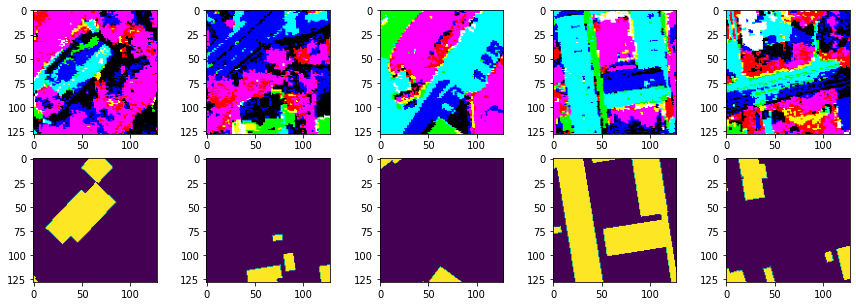

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (15,5))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    #ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
    #                          X_train[indx[i]][:,:,46],
    #                          X_train[indx[i]][:,:,21])))
    ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(y_train[indx[i]].argmax(axis=2))
plt.show()

### Set up u net

In [31]:
input_img = Input(shape=(128,128,6))
model = SharpUNet(input_img, num_classes=2)

model.compile(optimizer=Adam(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [32]:
h = model.fit(X_train, y_train, 
           validation_data=(X_val,y_val), 
           batch_size=20,
           epochs=250)

Epoch 1/250
50/50 [==============================] - 7s 116ms/step - loss: 595.1322 - accuracy: 0.8095 - val_loss: 0.6154 - val_accuracy: 0.8303
Epoch 2/250
50/50 [==============================] - 5s 100ms/step - loss: 0.5576 - accuracy: 0.8382 - val_loss: 0.5192 - val_accuracy: 0.8302
Epoch 3/250
50/50 [==============================] - 5s 101ms/step - loss: 0.4899 - accuracy: 0.8382 - val_loss: 0.4798 - val_accuracy: 0.8301
Epoch 4/250
50/50 [==============================] - 5s 101ms/step - loss: 0.4615 - accuracy: 0.8382 - val_loss: 0.4640 - val_accuracy: 0.8301
Epoch 5/250
50/50 [==============================] - 5s 102ms/step - loss: 0.4498 - accuracy: 0.8382 - val_loss: 0.4581 - val_accuracy: 0.8301
Epoch 6/250
50/50 [==============================] - 5s 101ms/step - loss: 0.4452 - accuracy: 0.8382 - val_loss: 0.4561 - val_accuracy: 0.8301
Epoch 7/250
50/50 [==============================] - 5s 101ms/step - loss: 0.4434 - accuracy: 0.8382 - val_loss: 0.4556 - val_accuracy: 0.83

KeyboardInterrupt: ignored

In [ ]:
plt.plot(h.history['loss'][30:])
plt.plot(h.history['val_loss'][30:])
plt.grid()

### Validate prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


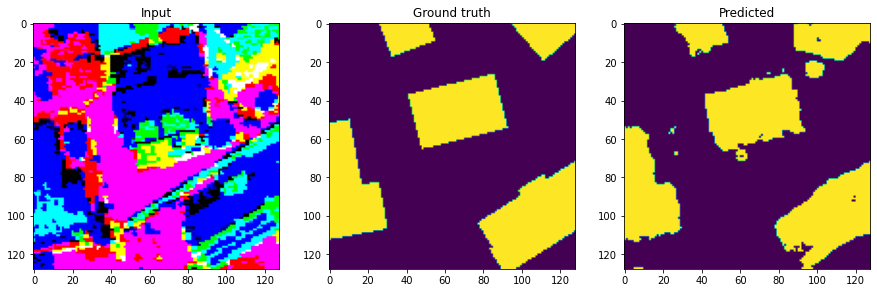

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


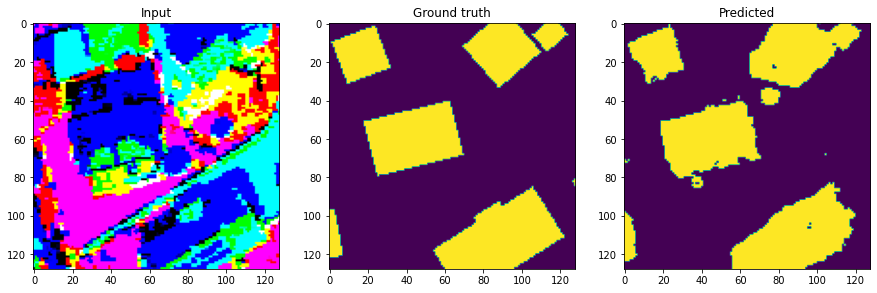

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


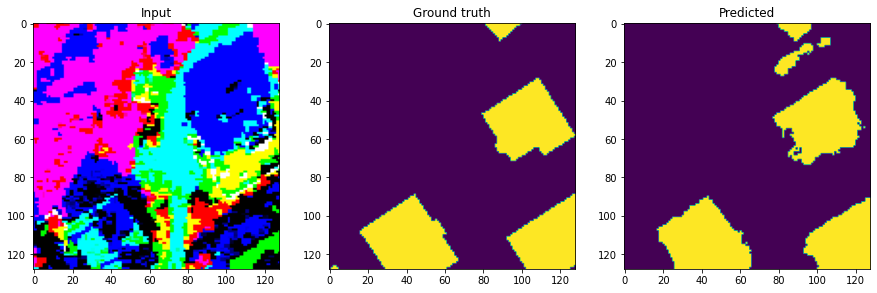

In [19]:
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
  #                      X_val[x:x+1][0][:,:,46],
  #                      X_val[x:x+1][0][:,:,21])))
  ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  pred = model.predict(X_val[x:x+1])[0].argmax(axis=2)
  ax3.imshow(pred)
  ax3.set_title("Predicted")
  plt.show()

## Test on unseen data

In [20]:
pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [21]:
print("Metrics on whole pred and useen")
print(f"f1 score: {f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
f1 score: 0.5869804856249069
acc score: 0.9204637451171875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


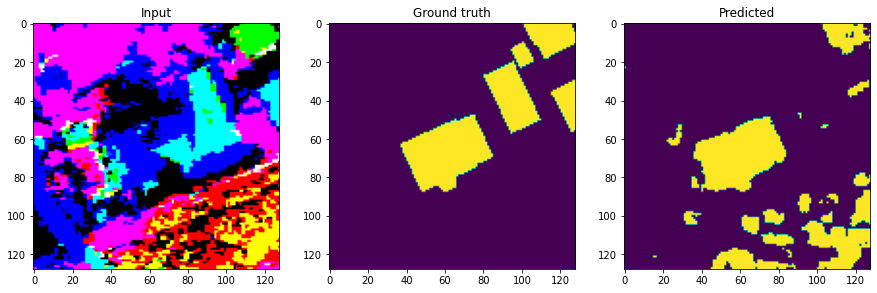

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.8529052734375
f1 score: 0.5437334343051874


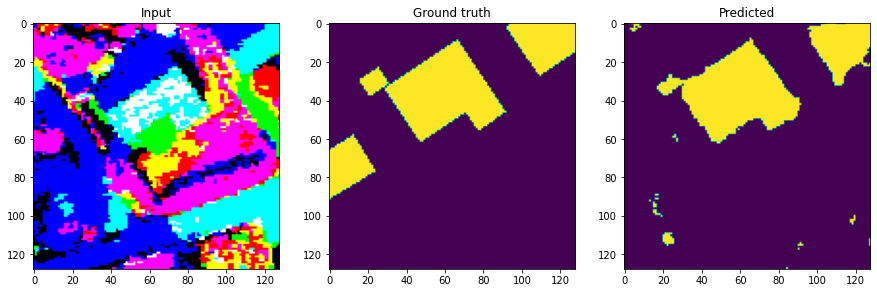

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.9454345703125
f1 score: 0.8448993754337265


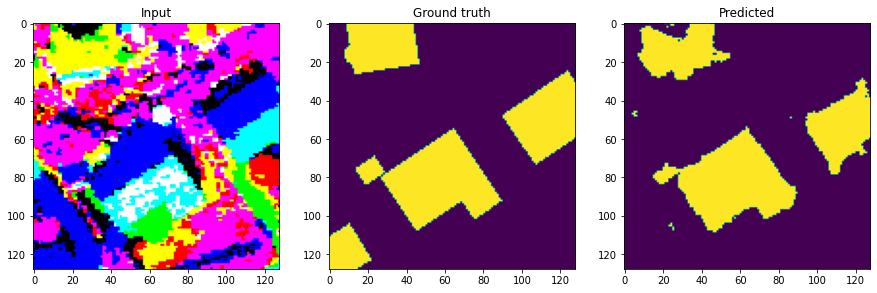

Acc score: 0.9276123046875
f1 score: 0.8519720419370944


In [22]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
  #                      X_test[x:x+1][0][:,:,46],
  #                      X_test[x:x+1][0][:,:,21])))
  ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0].argmax(axis=2))
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

In [ ]:
import seaborn as sns
sns.displot(pred[:,:,:,0])

ValueError: ignored

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)
